In [1]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the data
churn=pd.read_csv('telecom_churn_data.csv')

In [3]:
#  viewing number of columns and rows in the data
churn.shape

(99999, 226)

In [4]:
#  Overview about data
churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


**Data Preparation**

In [5]:
# Calculating the average recharge amount for the first two months (good phase)
churn['avg_rech_good_phase'] = churn[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1)

# Calculating the 70th percentile of this average recharge amount
threshold_X = churn['avg_rech_good_phase'].quantile(0.70)

# Marking customers as high-value if their average recharge amount is greater than or equal to threshold percenrtile 70%
churn['high_value_customer'] = churn['avg_rech_good_phase'] >= threshold_X

# filtering high value customers
df=churn[churn['high_value_customer']==True]
df.shape

(30011, 228)

In [6]:
# Tagging churners based on the churn criteria
df['churn'] = ((df['total_ic_mou_9'] == 0) &
                (df['total_og_mou_9'] == 0) &
                (df['vol_2g_mb_9'] == 0) &
                (df['vol_3g_mb_9'] == 0)).astype(int)

# Droping all columns related to the churn phase (ending with '_9')
df = df.drop(columns=[col for col in df.columns if col.endswith('_9')])
df.shape

(30011, 175)

In [7]:
# Checking for null values in dataset
100*df.isna().mean().sort_values(ascending=False)

arpu_3g_6                   62.023925
av_rech_amt_data_6          62.023925
date_of_last_rech_data_6    62.023925
max_rech_data_6             62.023925
count_rech_2g_6             62.023925
                              ...    
vol_2g_mb_6                  0.000000
vol_2g_mb_7                  0.000000
vol_2g_mb_8                  0.000000
vol_3g_mb_6                  0.000000
churn                        0.000000
Length: 175, dtype: float64

In [8]:
# Removing columns having more than 40% null values
df=df.drop([i for i in df.columns if 100*df[i].isna().mean()>40],axis=1)
df.shape

(30011, 145)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30011 entries, 7 to 99997
Columns: 145 entries, mobile_number to churn
dtypes: bool(1), float64(110), int32(1), int64(27), object(6)
memory usage: 33.1+ MB


In [10]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [11]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

# Checking and handling missing values for columns with null data
# Here we fill NaNs in numeric columns with their mean or zero (e.g., if they are counts or amounts)
# For object-type columns (dates), we fill forward, as these might be sequential.
threshold = len(df)  
for col in df.columns:
    if df[col].count() < threshold:
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            df[col].fillna(df[col].mean(), inplace=True)  # Filling numeric NaNs with mean
        elif df[col].dtype == 'object':
            df[col].fillna(method='ffill', inplace=True)  # Filling object NaNs forward
# Converting date columns to datetime format
date_cols = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
             'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [12]:
# checking for null values again
df.isna().sum().sum()

0

In [13]:
# Handling outliers
def remove_outliers_iqr(df, columns, factor=1.5):
    for col in columns:
        # Calculate Q1 and Q3
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        # Define bounds for outliers
        lower_bound = Q1 - (factor * IQR)
        upper_bound = Q3 + (factor * IQR)
        # Remove rows outside of the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [14]:
df.shape

(30011, 145)

**Feature Scaling**

In [15]:
# droppnig date columns as these are of no use for our analysis
date_cols = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
             'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [16]:
df.drop(columns=date_cols, inplace=True)

In [17]:
# Defining X and y
X=df.drop(['churn','mobile_number','circle_id'],axis=1)
X.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_good_phase,high_value_customer
7,0.0,0.0,0.0,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,...,0,0,0,802,57.74,19.38,18.74,0.0,1185.0,True
8,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,35.08,94.66,...,0,0,0,315,21.03,910.65,122.16,0.0,519.0,True
13,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,413.31,...,0,0,0,2607,0.00,0.00,0.00,0.0,380.0,True
16,0.0,0.0,0.0,430.975,299.869,187.894,50.51,74.01,70.61,296.29,...,0,0,0,511,0.00,2.45,21.89,0.0,459.0,True
17,0.0,0.0,0.0,690.008,18.980,25.499,1185.91,9.28,7.79,61.64,...,0,0,0,667,0.00,0.00,0.00,0.0,408.0,True


In [18]:
y=df['churn']
y.head()

7     1
8     0
13    0
16    0
17    0
Name: churn, dtype: int32

In [19]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)
X_train.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_good_phase,high_value_customer
4715,0.0,0.0,0.0,331.304,480.315,386.671,336.33,564.78,424.11,154.94,...,0,0,0,353,0.00,0.00,0.00,0.00,461.5,True
15222,0.0,0.0,0.0,320.013,508.681,480.398,110.08,27.54,131.03,220.86,...,0,0,0,1076,170.16,67.21,48.78,12.56,464.0,True
60145,0.0,0.0,0.0,289.191,802.774,562.645,26.19,83.34,84.73,206.61,...,0,0,0,2282,0.00,0.00,0.00,0.00,615.5,True
62445,0.0,0.0,0.0,491.912,570.752,544.894,177.03,419.24,108.21,641.28,...,0,0,0,2613,0.00,0.00,0.00,0.00,630.0,True
88349,0.0,0.0,0.0,631.214,596.405,277.594,118.18,239.38,63.86,475.76,...,0,0,0,439,0.00,0.00,0.00,0.00,700.0,True


In [20]:
# normalizing the data
num_cols=[col for col in X_train.columns]
scaler=StandardScaler()
X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
X_train.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_good_phase,high_value_customer
4715,0.0,0.0,0.0,-0.618756,-0.252174,-0.318969,0.079020,0.522979,0.303339,-0.568532,...,-0.153647,-0.151671,-0.136997,-0.938635,-0.329669,-0.330304,-0.310692,-0.132291,-0.520352,0.0
15222,0.0,0.0,0.0,-0.646107,-0.187018,-0.120157,-0.412342,-0.578286,-0.309876,-0.428047,...,-0.153647,-0.151671,-0.136997,-0.198224,0.104407,-0.168340,-0.185233,0.126594,-0.514834,0.0
60145,0.0,0.0,0.0,-0.720768,0.488501,0.054303,-0.594531,-0.463904,-0.406750,-0.458416,...,-0.153647,-0.151671,-0.136997,1.036820,-0.329669,-0.330304,-0.310692,-0.132291,-0.180472,0.0
62445,0.0,0.0,0.0,-0.229708,-0.044444,0.016650,-0.266942,0.224643,-0.357623,0.467928,...,-0.153647,-0.151671,-0.136997,1.375791,-0.329669,-0.330304,-0.310692,-0.132291,-0.148470,0.0
88349,0.0,0.0,0.0,0.107729,0.014480,-0.550340,-0.394751,-0.144044,-0.450417,0.115181,...,-0.153647,-0.151671,-0.136997,-0.850564,-0.329669,-0.330304,-0.310692,-0.132291,0.006020,0.0


In [21]:
logml=sm.GLM(y_train,(sm.add_constant(X_train)),family=sm.families.Binomial())
logml.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20881
Model Family:                Binomial   Df Model:                          125
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3744.5
Date:                Sat, 02 Nov 2024   Deviance:                       7489.0
Time:                        07:53:07   Pearson chi2:                 6.39e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2083
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.9473      0.074    -53.369      0.000      -4.092      -3.802
loc_og_t2o_mou       1.181e-07    5.3e-08      2.230      0.026    1.43e-08    2.22e-07
std_og_t2o_mou       1.633e-07   8.62e-08      1.894      0.058   -5.69e-09    3.32e-07
loc_ic_t2o_mou      -5.157e-07    1.5e-07     -3.445      0.001   -8.09e-07   -2.22e-07
arpu_6                  0.0765      0.110      0.695      0.487      -0.139       0.292
arpu_7                  0.2351      0.126      1.863      0.063      -0.012       0.483
arpu_8                  0.4710      0.168      2.796      0.005       0.141       0.801
onnet_mou_6            -1.5974      3.044     -0.525      0.600      -7.564       4.369
onnet_mou_7            -0.9565      2.149     -0.445      0.656      -5.168       3.255
onnet_mou_8             0.2234      1.756      0.127      0.899      -3.219       3.666
offnet_mou_6           -1.1689      3.084     -0.379      0.705      -7.214       4.876
offnet_mou_7           -1.1925      2.114     -0.564      0.573      -5.337       2.952
offnet_mou_8           -0.4447      1.739     -0.256      0.798      -3.853       2.964
roam_ic_mou_6           0.0169      0.035      0.478      0.632      -0.052       0.086
roam_ic_mou_7           0.0465      0.039      1.196      0.232      -0.030       0.123
roam_ic_mou_8          -0.0007      0.037     -0.020      0.984      -0.073       0.072
roam_og_mou_6           0.3684      0.768      0.479      0.632      -1.138       1.875
roam_og_mou_7           0.2911      0.430      0.677      0.498      -0.551       1.133
roam_og_mou_8           0.0373      0.378      0.099      0.921      -0.704       0.778
loc_og_t2t_mou_6       40.9299   1348.751      0.030      0.976   -2602.574    2684.434
loc_og_t2t_mou_7     1182.6570   1442.607      0.820      0.412   -1644.801    4010.115
loc_og_t2t_mou_8     5802.9013   1580.129      3.672      0.000    2705.906    8899.896
loc_og_t2m_mou_6       42.9743   1432.958      0.030      0.976   -2765.572    2851.521
loc_og_t2m_mou_7     1117.7473   1363.293      0.820      0.412   -1554.258    3789.752
loc_og_t2m_mou_8     5599.8492   1524.671      3.673      0.000    2611.549    8588.150
loc_og_t2f_mou_6        4.0372    133.644      0.030      0.976    -257.900     265.974
loc_og_t2f_mou_7      109.4908    133.567      0.820      0.412    -152.296     371.278
loc_og_t2f_mou_8      491.5072    133.810      3.673      0.000     229.244     753.770
loc_og_t2c_mou_6        0.0028      0.030      0.094      0.925      -0.056       0.061
loc_og_t2c_mou_7        0.0850      0.042      2.038      0.042       0.003       0.167
loc_og_t2c_mou_8       -0.0228      0.047     -0.483      0.629      -0.115       0.070
loc_og_mou_6         1600.0244   2249.621      0.711      0.477   -2809.151    6009.200
loc

**Feature selection using RFE**

In [22]:
logreg=LogisticRegression()

In [23]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=logreg, n_features_to_select=15)
rfe=rfe.fit(X_train, y_train)

In [24]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('loc_og_t2o_mou', False, 122),
 ('std_og_t2o_mou', False, 121),
 ('loc_ic_t2o_mou', False, 120),
 ('arpu_6', False, 41),
 ('arpu_7', False, 2),
 ('arpu_8', False, 18),
 ('onnet_mou_6', False, 54),
 ('onnet_mou_7', False, 91),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 9),
 ('offnet_mou_7', False, 50),
 ('offnet_mou_8', False, 45),
 ('roam_ic_mou_6', False, 106),
 ('roam_ic_mou_7', False, 46),
 ('roam_ic_mou_8', False, 97),
 ('roam_og_mou_6', False, 100),
 ('roam_og_mou_7', False, 34),
 ('roam_og_mou_8', False, 61),
 ('loc_og_t2t_mou_6', False, 12),
 ('loc_og_t2t_mou_7', False, 57),
 ('loc_og_t2t_mou_8', False, 4),
 ('loc_og_t2m_mou_6', False, 16),
 ('loc_og_t2m_mou_7', False, 49),
 ('loc_og_t2m_mou_8', False, 15),
 ('loc_og_t2f_mou_6', False, 107),
 ('loc_og_t2f_mou_7', False, 88),
 ('loc_og_t2f_mou_8', False, 48),
 ('loc_og_t2c_mou_6', False, 109),
 ('loc_og_t2c_mou_7', False, 47),
 ('loc_og_t2c_mou_8', False, 96),
 ('loc_og_mou_6', False, 87),
 ('loc_og_mou_7', False, 93),

In [25]:
col=X_train.columns[rfe.support_]
col

Index(['onnet_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'total_og_mou_8',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'std_ic_mou_8',
       'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'last_day_rch_amt_8', 'monthly_2g_8', 'monthly_3g_8', 'sep_vbc_3g'],
      dtype='object')

In [26]:
x_train_sm=sm.add_constant(X_train[col])
logm2=sm.GLM(y_train,x_train_sm,family=sm.families.Binomial())
res=logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20991
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4068.3
Date:                Sat, 02 Nov 2024   Deviance:                       8136.6
Time:                        07:54:36   Pearson chi2:                 5.37e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1835
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.0863      0.076    -53.555      0.000      -4.236      -3.937
onnet_mou_8            0.6816      0.152      4.493      0.000       0.384       0.979
std_og_t2t_mou_8       0.3207      0.151      2.125      0.034       0.025       0.616
std_og_t2m_mou_8       0.9176      0.144      6.352      0.000       0.634       1.201
total_og_mou_8        -2.0715      0.225     -9.195      0.000      -2.513      -1.630
loc_ic_t2t_mou_8       0.6243      0.170      3.673      0.000       0.291       0.958
loc_ic_t2m_mou_8       1.0296      0.146      7.031      0.000       0.743       1.317
std_ic_mou_8           1.1327      0.128      8.816      0.000       0.881       1.384
total_ic_mou_7         0.7507      0.060     12.505      0.000       0.633       0.868
total_ic_mou_8        -4.2884      0.289    -14.832      0.000      -4.855      -3.722
spl_ic_mou_8          -0.4917      0.073     -6.698      0.000      -0.636      -0.348
isd_ic_mou_8           0.6980      0.073      9.565      0.000       0.555       0.841
last_day_rch_amt_8    -0.4638      0.063     -7.312      0.000      -0.588      -0.339
monthly_2g_8          -0.5095      0.068     -7.500      0.000      -0.643      -0.376
monthly_3g_8          -0.6363      0.074     -8.543      0.000      -0.782      -0.490
sep_vbc_3g            -0.8918      0.246     -3.632      0.000      -1.373      -0.411
======================================================================================
"""

In [27]:
# Getting the predicted values on trained set
y_train_pred=res.predict(x_train_sm)
y_train_pred[:10]

4715     0.141942
15222    0.000661
60145    0.049679
62445    0.083739
88349    0.009441
71755    0.017647
12269    0.098046
60558    0.012079
56742    0.040988
16606    0.006777
dtype: float64

In [28]:
y_train_pred_final=pd.DataFrame({'churn':y_train.values,'churn_prob':y_train_pred})
y_train_pred_final['Cust_id']=y_train_pred.index
y_train_pred_final.head()

,churn,churn_prob,Cust_id
4715,0,0.141942,4715
15222,0,0.000661,15222
60145,0,0.049679,60145
62445,0,0.083739,62445
88349,0,0.009441,88349


In [29]:
y_train_pred_final['Predicted']=y_train_pred_final.churn_prob.map(lambda x: 1 if x>0.5 else 0)
y_train_pred_final.head()

,churn,churn_prob,Cust_id,Predicted
4715,0,0.141942,4715,0
15222,0,0.000661,15222,0
60145,0,0.049679,60145,0
62445,0,0.083739,62445,0
88349,0,0.009441,88349,0


In [30]:
from sklearn import metrics

In [31]:
confusion=metrics.confusion_matrix(y_train_pred_final.churn,y_train_pred_final.Predicted)
print(confusion)

[[19047   137]
 [ 1295   528]]


In [32]:
print(metrics.accuracy_score(y_train_pred_final.churn,y_train_pred_final.Predicted))

0.9318322463940591


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
vif=pd.DataFrame()
vif['features']=X_train[col].columns
vif['VIF']=[variance_inflation_factor(X_train[col].values,i) for i in range(X_train[col].shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)
vif

,features,VIF
8,total_ic_mou_8,34.27
5,loc_ic_t2m_mou_8,12.26
3,total_og_mou_8,9.64
0,onnet_mou_8,9.05
4,loc_ic_t2t_mou_8,7.29
6,std_ic_mou_8,6.14
2,std_og_t2m_mou_8,4.51
1,std_og_t2t_mou_8,4.07
7,total_ic_mou_7,2.98
10,isd_ic_mou_8,2.42


In [35]:
col=col.drop('total_ic_mou_8',1)

In [36]:
x_train_sm=sm.add_constant(X_train[col])
logm3=sm.GLM(y_train,x_train_sm,family=sm.families.Binomial())
res=logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20992
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4179.2
Date:                Sat, 02 Nov 2024   Deviance:                       8358.5
Time:                        07:54:37   Pearson chi2:                 4.84e+10
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1748
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.2216      0.077    -54.838      0.000      -4.373      -4.071
onnet_mou_8            1.4862      0.167      8.874      0.000       1.158       1.814
std_og_t2t_mou_8       1.5366      0.175      8.776      0.000       1.193       1.880
std_og_t2m_mou_8       2.8769      0.096     29.941      0.000       2.689       3.065
total_og_mou_8        -5.3133      0.139    -38.218      0.000      -5.586      -5.041
loc_ic_t2t_mou_8      -0.6086      0.114     -5.349      0.000      -0.832      -0.386
loc_ic_t2m_mou_8      -0.6511      0.083     -7.846      0.000      -0.814      -0.488
std_ic_mou_8          -0.4235      0.072     -5.904      0.000      -0.564      -0.283
total_ic_mou_7         0.4881      0.053      9.266      0.000       0.385       0.591
spl_ic_mou_8          -0.4501      0.066     -6.835      0.000      -0.579      -0.321
isd_ic_mou_8          -0.1049      0.045     -2.351      0.019      -0.192      -0.017
last_day_rch_amt_8    -0.5064      0.066     -7.623      0.000      -0.637      -0.376
monthly_2g_8          -0.5346      0.068     -7.882      0.000      -0.668      -0.402
monthly_3g_8          -0.5966      0.072     -8.329      0.000      -0.737      -0.456
sep_vbc_3g            -0.9982      0.255     -3.908      0.000      -1.499      -0.498
======================================================================================
"""

In [37]:
y_train_pred=res.predict(x_train_sm).values.reshape(-1)

In [38]:
y_train_pred[:10]

array([0.15830597, 0.00351496, 0.01251332, 0.04928465, 0.01394636,
       0.01560152, 0.11846136, 0.01818179, 0.03547654, 0.00272599])

In [39]:
y_train_pred_final['churn_prob']=y_train_pred
y_train_pred_final.head()

,churn,churn_prob,Cust_id,Predicted
4715,0,0.158306,4715,0
15222,0,0.003515,15222,0
60145,0,0.012513,60145,0
62445,0,0.049285,62445,0
88349,0,0.013946,88349,0


In [40]:
y_train_pred_final['Predicted']=y_train_pred_final.churn_prob.map(lambda x: 1 if x>0.5 else 0)
y_train_pred_final.head()

,churn,churn_prob,Cust_id,Predicted
4715,0,0.158306,4715,0
15222,0,0.003515,15222,0
60145,0,0.012513,60145,0
62445,0,0.049285,62445,0
88349,0,0.013946,88349,0


In [41]:
confusion=metrics.confusion_matrix(y_train_pred_final.churn,y_train_pred_final.Predicted)
print(confusion)

[[19059   125]
 [ 1300   523]]


In [42]:
print(metrics.accuracy_score(y_train_pred_final.churn,y_train_pred_final.Predicted))

0.9321654686533061


In [43]:
vif=pd.DataFrame()
vif['features']=X_train[col].columns
vif['VIF']=[variance_inflation_factor(X_train[col].values,i) for i in range(X_train[col].shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)
vif

,features,VIF
0,onnet_mou_8,8.35
3,total_og_mou_8,8.28
1,std_og_t2t_mou_8,4.07
2,std_og_t2m_mou_8,4.01
7,total_ic_mou_7,2.79
5,loc_ic_t2m_mou_8,1.99
4,loc_ic_t2t_mou_8,1.51
6,std_ic_mou_8,1.27
10,last_day_rch_amt_8,1.09
9,isd_ic_mou_8,1.08


In [44]:
col=col.drop('onnet_mou_8',1)

In [45]:
x_train_sm=sm.add_constant(X_train[col])
logm3=sm.GLM(y_train,x_train_sm,family=sm.families.Binomial())
res=logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20993
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4219.4
Date:                Sat, 02 Nov 2024   Deviance:                       8438.8
Time:                        07:54:38   Pearson chi2:                 6.01e+10
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1717
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.3445      0.077    -56.579      0.000      -4.495      -4.194
std_og_t2t_mou_8       2.8834      0.095     30.446      0.000       2.698       3.069
std_og_t2m_mou_8       2.8895      0.097     29.723      0.000       2.699       3.080
total_og_mou_8        -5.3757      0.141    -38.023      0.000      -5.653      -5.099
loc_ic_t2t_mou_8      -0.4367      0.099     -4.415      0.000      -0.631      -0.243
loc_ic_t2m_mou_8      -0.6174      0.080     -7.692      0.000      -0.775      -0.460
std_ic_mou_8          -0.4100      0.071     -5.802      0.000      -0.548      -0.271
total_ic_mou_7         0.4612      0.053      8.743      0.000       0.358       0.565
spl_ic_mou_8          -0.4548      0.065     -7.006      0.000      -0.582      -0.328
isd_ic_mou_8          -0.1029      0.045     -2.296      0.022      -0.191      -0.015
last_day_rch_amt_8    -0.4259      0.063     -6.749      0.000      -0.550      -0.302
monthly_2g_8          -0.5468      0.068     -8.070      0.000      -0.680      -0.414
monthly_3g_8          -0.6040      0.071     -8.517      0.000      -0.743      -0.465
sep_vbc_3g            -0.9963      0.252     -3.958      0.000      -1.490      -0.503
======================================================================================
"""

In [46]:
y_train_pred=res.predict(x_train_sm).values.reshape(-1)

In [47]:
y_train_pred_final['churn_prob']=y_train_pred
y_train_pred_final.head()

,churn,churn_prob,Cust_id,Predicted
4715,0,0.168626,4715,0
15222,0,0.002851,15222,0
60145,0,0.010382,60145,0
62445,0,0.038211,62445,0
88349,0,0.014759,88349,0


In [48]:
y_train_pred_final['Predicted']=y_train_pred_final.churn_prob.map(lambda x: 1 if x>0.5 else 0)
y_train_pred_final.head()

,churn,churn_prob,Cust_id,Predicted
4715,0,0.168626,4715,0
15222,0,0.002851,15222,0
60145,0,0.010382,60145,0
62445,0,0.038211,62445,0
88349,0,0.014759,88349,0


In [49]:
confusion=metrics.confusion_matrix(y_train_pred_final.churn,y_train_pred_final.Predicted)
print(confusion)

[[19084   100]
 [ 1312   511]]


In [50]:
print(metrics.accuracy_score(y_train_pred_final.churn,y_train_pred_final.Predicted))

0.9327843099919074


In [51]:
vif=pd.DataFrame()
vif['features']=X_train[col].columns
vif['VIF']=[variance_inflation_factor(X_train[col].values,i) for i in range(X_train[col].shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)
vif

,features,VIF
2,total_og_mou_8,3.97
6,total_ic_mou_7,2.79
1,std_og_t2m_mou_8,2.43
0,std_og_t2t_mou_8,2.35
4,loc_ic_t2m_mou_8,1.91
3,loc_ic_t2t_mou_8,1.47
5,std_ic_mou_8,1.27
8,isd_ic_mou_8,1.08
9,last_day_rch_amt_8,1.07
11,monthly_3g_8,1.05


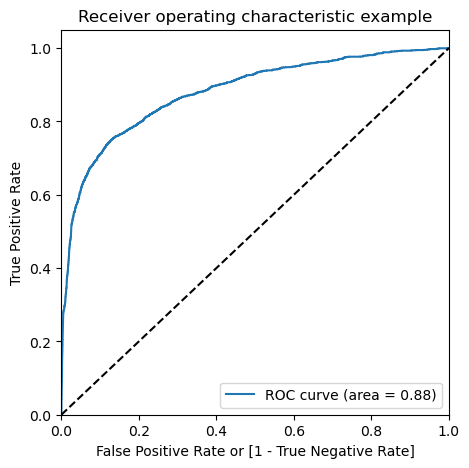

In [52]:
# Defining the function to plot the ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

# Calling the function
draw_roc(y_train_pred_final.churn, y_train_pred_final.churn_prob)



In [53]:
numbers=[float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]=y_train_pred_final.churn_prob.map( lambda x: 1 if x>i else 0)
y_train_pred_final.head()

,churn,churn_prob,Cust_id,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
4715,0,0.168626,4715,0,1,1,0,0,0,0,0,0,0,0
15222,0,0.002851,15222,0,1,0,0,0,0,0,0,0,0,0
60145,0,0.010382,60145,0,1,0,0,0,0,0,0,0,0,0
62445,0,0.038211,62445,0,1,0,0,0,0,0,0,0,0,0
88349,0,0.014759,88349,0,1,0,0,0,0,0,0,0,0,0


In [54]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.086781  1.000000  0.000000
0.1   0.1  0.792355  0.800329  0.791597
0.2   0.2  0.897225  0.685134  0.917379
0.3   0.3  0.931309  0.551289  0.967421
0.4   0.4  0.931499  0.297312  0.991764
0.5   0.5  0.932784  0.280307  0.994787
0.6   0.6  0.932975  0.277564  0.995256
0.7   0.7  0.927215  0.190346  0.997237
0.8   0.8  0.914838  0.020845  0.999791
0.9   0.9  0.913743  0.006034  1.000000


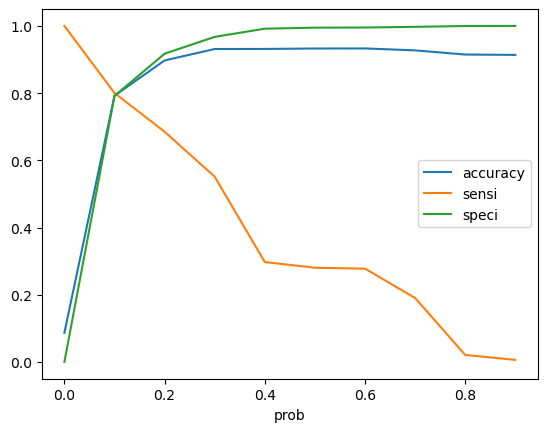

In [55]:
cutoff_df.plot.line(x='prob',y=['accuracy','sensi','speci'])
plt.show()

0.15 is the thresold value

In [56]:
from sklearn.metrics import precision_score,recall_score

In [57]:
precision_score(y_train_pred_final.churn,y_train_pred_final.Predicted)

0.8363338788870703

**Testing The Model On Test Set**

In [58]:
num_cols=[col for col in X_test.columns]
X_test[num_cols]=scaler.transform(X_test[num_cols])
X_test.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_good_phase,high_value_customer
29360,0.0,0.0,0.0,0.653253,-0.585738,-1.139187,-0.604413,-0.564962,-0.577734,3.173222,...,-0.153647,-0.151671,-0.136997,-0.744060,-0.329669,-0.330304,-0.310692,-0.132291,-0.032602,0.0
49979,0.0,0.0,0.0,0.227524,0.147692,-0.765875,1.807659,2.115820,-0.041119,0.058429,...,-0.153647,-0.151671,-0.136997,-0.444003,-0.329669,-0.330304,-0.310692,-0.132291,0.115267,0.0
90612,0.0,0.0,0.0,-0.726870,-0.188713,0.145127,-0.640898,-0.632217,-0.575746,-0.854425,...,-0.153647,-0.151671,-0.136997,1.879640,0.541315,-0.034354,0.119592,-0.132291,-0.453038,0.0
87007,0.0,0.0,0.0,-0.135557,-0.067866,-0.099690,-0.626348,-0.585665,-0.558736,-0.319955,...,-0.153647,-0.151671,-0.136997,1.302057,-0.329669,-0.330304,-0.310692,-0.132291,-0.184886,0.0
91852,0.0,0.0,0.0,-0.514188,-0.691419,-0.530607,4.177469,2.399069,2.581489,-0.861138,...,-0.153647,-0.151671,-0.136997,-0.713337,0.513918,-0.057416,-0.185516,-0.132291,-0.717879,0.0


In [59]:
X_test=X_test[col]
X_test.head()

,std_og_t2t_mou_8,std_og_t2m_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,std_ic_mou_8,total_ic_mou_7,spl_ic_mou_8,isd_ic_mou_8,last_day_rch_amt_8,monthly_2g_8,monthly_3g_8,sep_vbc_3g
29360,-0.425640,-0.431957,-0.878955,-0.295077,-0.041425,0.003860,-0.042352,-0.257364,-0.157563,-0.648167,-0.316581,-0.301673,-0.132291
49979,0.093500,-0.310015,-0.427013,-0.430655,-0.727283,-0.253169,-0.155535,-0.257364,-0.157563,1.050325,-0.316581,-0.301673,-0.132291
90612,-0.428617,-0.440129,-0.837707,-0.373474,0.083281,-0.345403,-0.526937,-0.257364,-0.157563,1.063913,-0.316581,3.099050,-0.132291
87007,-0.428617,-0.440129,-0.569127,-0.320498,0.472029,-0.339212,0.214303,-0.257364,-0.157563,-0.444348,-0.316581,-0.301673,-0.132291
91852,-0.428617,-0.437032,1.266465,-0.329223,-0.093939,-0.279512,-0.330888,-0.257364,-0.157563,-0.491906,-0.316581,-0.301673,-0.132291


In [60]:
X_test_sm=sm.add_constant(X_test)

In [61]:
y_test_pred=res.predict(X_test_sm)

In [62]:
y_test_pred[:10]

29360    0.256306
49979    0.137883
90612    0.014409
87007    0.052318
91852    0.000003
28100    0.037630
69301    0.306134
50905    0.006918
31097    0.103579
83157    0.356908
dtype: float64

In [63]:
y_pred_1=pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
29360,0.256306
49979,0.137883
90612,0.014409
87007,0.052318
91852,0.000003


In [64]:
y_test_df=pd.DataFrame(y_test)

In [65]:
y_test_df['CustId']=y_test_df.index

In [66]:
y_pred_1.reset_index(drop=True,inplace=True)
y_test_df.reset_index(drop=True,inplace=True)

In [67]:
y_pred_final=pd.concat([y_test_df,y_pred_1],axis=1)

In [68]:
y_pred_final.head()

,churn,CustId,0
0,0,29360,0.256306
1,0,49979,0.137883
2,0,90612,0.014409
3,0,87007,0.052318
4,0,91852,0.000003


In [69]:
y_pred_final=y_pred_final.rename(columns={0:'churn_prob'})

In [70]:
y_pred_final = y_pred_final[['CustId', 'churn', 'churn_prob']]

In [71]:
y_pred_final.head()

,CustId,churn,churn_prob
0,29360,0,0.256306
1,49979,0,0.137883
2,90612,0,0.014409
3,87007,0,0.052318
4,91852,0,0.000003


In [72]:
y_pred_final['final_predicted']=y_pred_final.churn_prob.map( lambda x : 1 if x>.15 else 0)

In [73]:
y_pred_final.head()

,CustId,churn,churn_prob,final_predicted
0,29360,0,0.256306,1
1,49979,0,0.137883,0
2,90612,0,0.014409,0
3,87007,0,0.052318,0
4,91852,0,0.000003,0


In [74]:
metrics.accuracy_score(y_pred_final.churn,y_pred_final.final_predicted)

0.8668369613505109

In [75]:
confusion_2=metrics.confusion_matrix(y_pred_final.churn,y_pred_final.final_predicted)
confusion_2

array([[7208, 1026],
       [ 173,  597]], dtype=int64)

In [76]:
TP=confusion_2[1,1]
TN=confusion_2[0,0]
FP=confusion_2[0,1]
FN=confusion_2[1,0]

In [77]:
# senstivity of model
TP/float(TP+FN)

0.7753246753246753

In [78]:
#  specificity of model
TN/float(TN+FP)

0.8753947048821957

**EDA**

Checkinhg relationship between variables

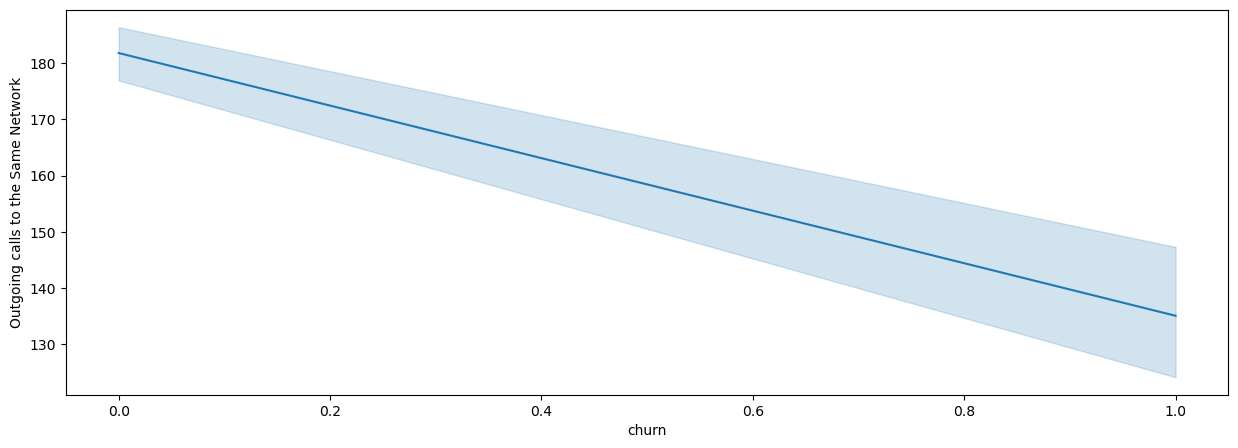

In [83]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['churn'],y=df['std_og_t2t_mou_8'])
plt.xlabel('churn')
plt.ylabel('Outgoing calls to the Same Network')
plt.show()

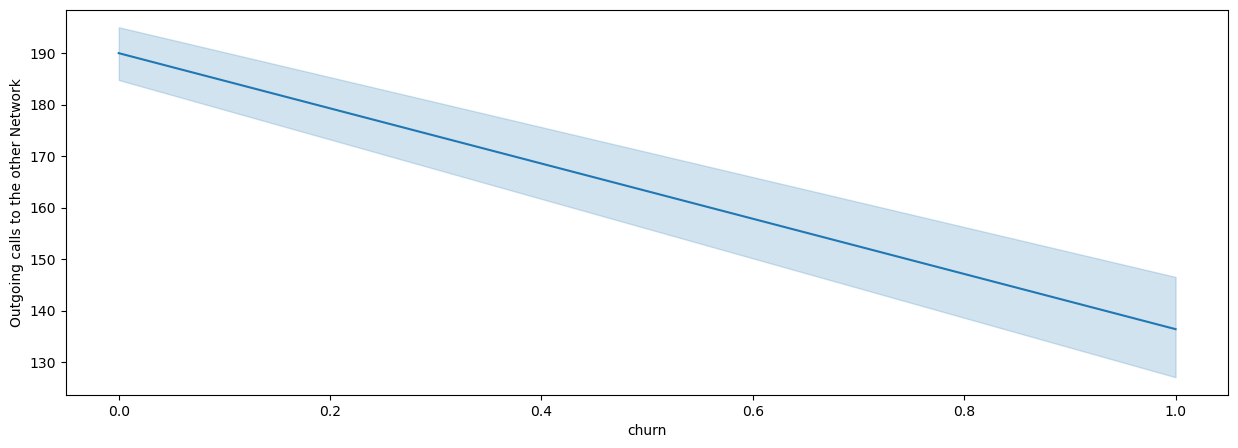

In [85]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['churn'],y=df['std_og_t2m_mou_8'])
plt.xlabel('churn')
plt.ylabel('Outgoing calls to the other Network')
plt.show()

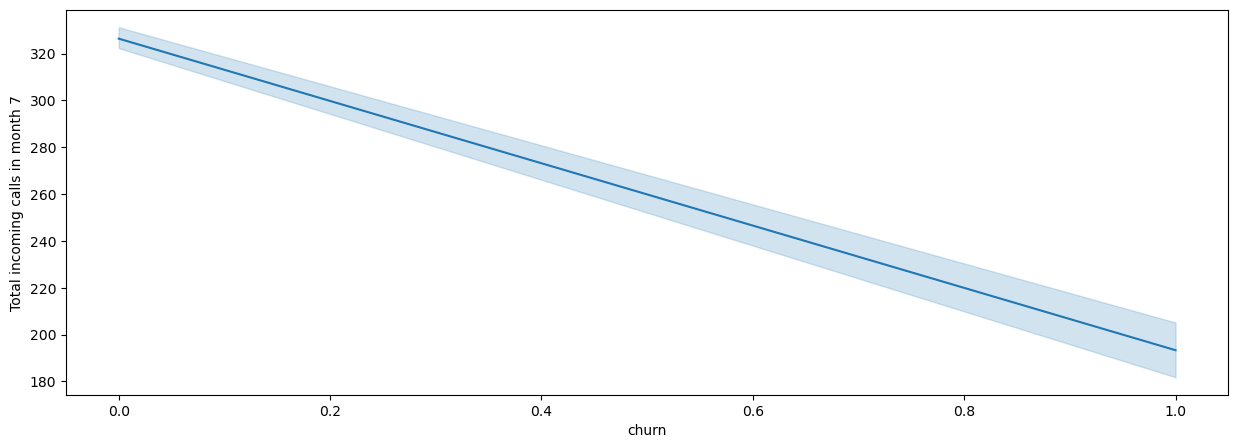

In [86]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['churn'],y=df['total_ic_mou_7'])
plt.xlabel('churn')
plt.ylabel('Total incoming calls in month 7')
plt.show()

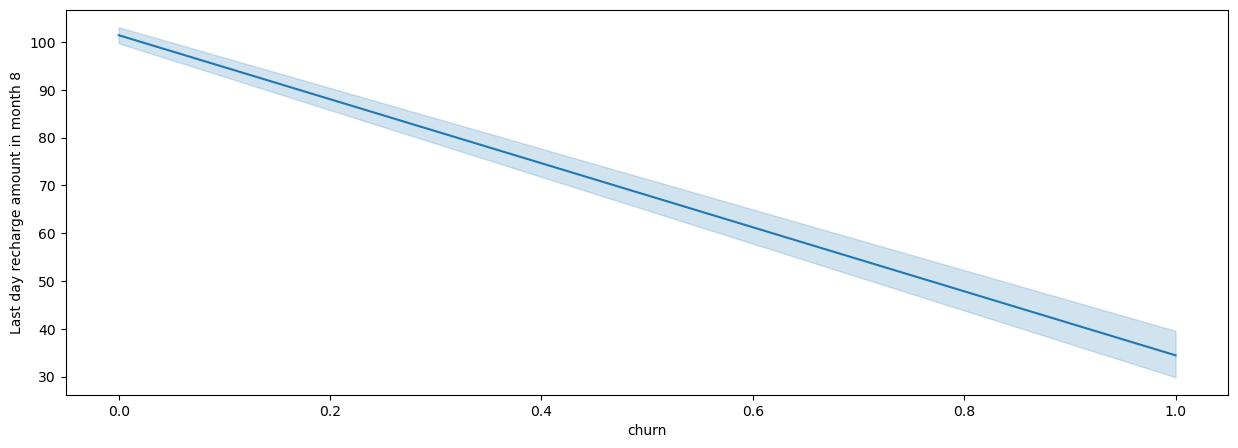

In [87]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['churn'],y=df['last_day_rch_amt_8'])
plt.xlabel('churn')
plt.ylabel('Last day recharge amount in month 8')
plt.show()

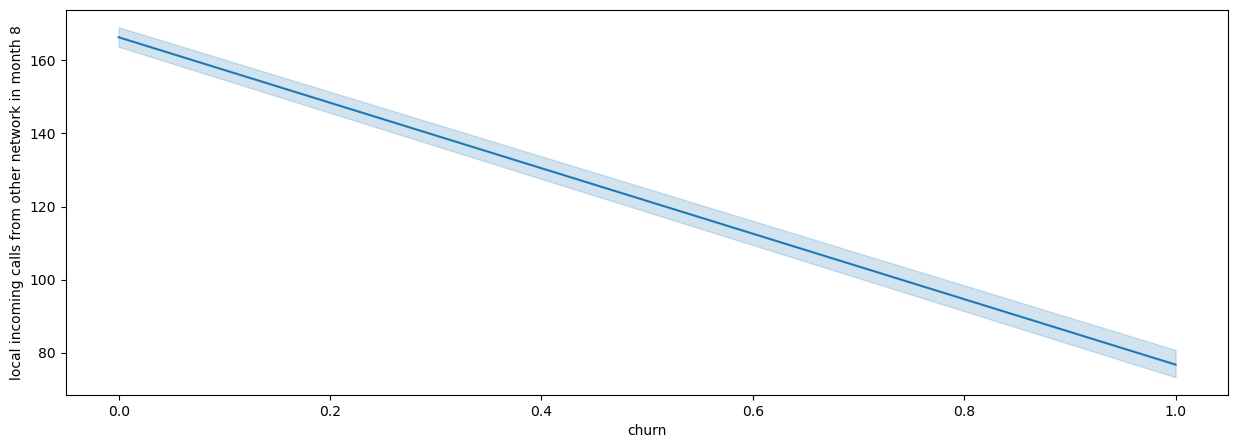

In [89]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['churn'],y=df['loc_ic_t2m_mou_8'])
plt.xlabel('churn')
plt.ylabel('local incoming calls from other network in month 8')
plt.show()

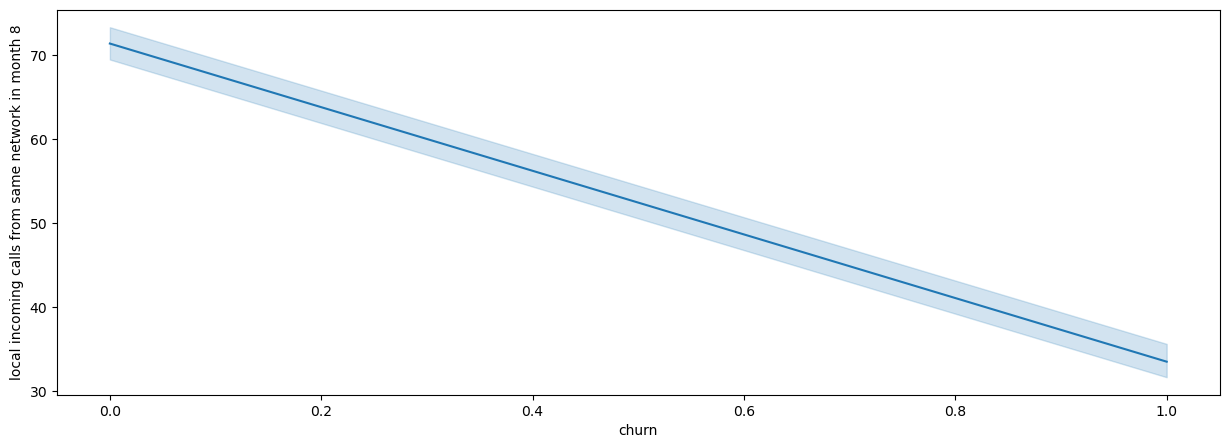

In [90]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['churn'],y=df['loc_ic_t2t_mou_8'])
plt.xlabel('churn')
plt.ylabel('local incoming calls from same network in month 8')
plt.show()

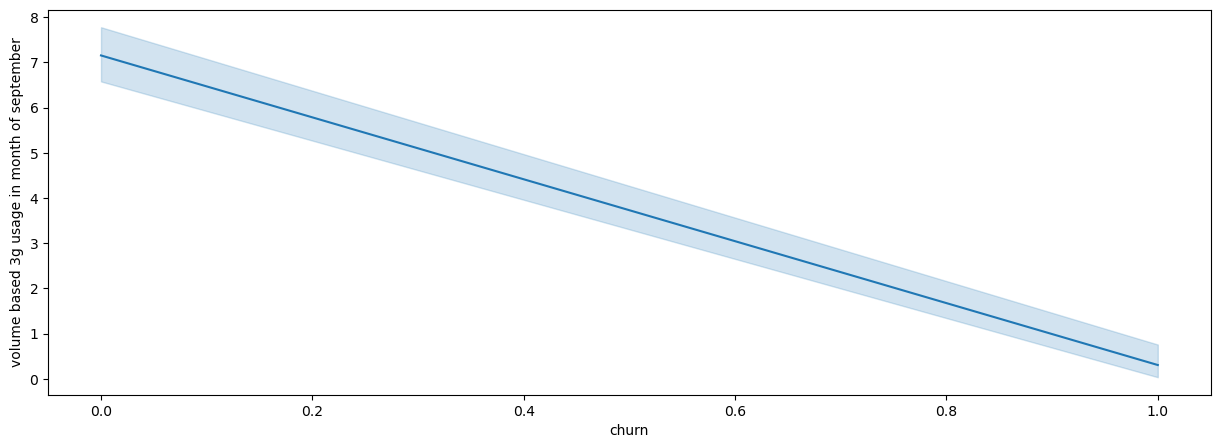

In [91]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['churn'],y=df['sep_vbc_3g'])
plt.xlabel('churn')
plt.ylabel('volume based 3g usage in month of september')
plt.show()

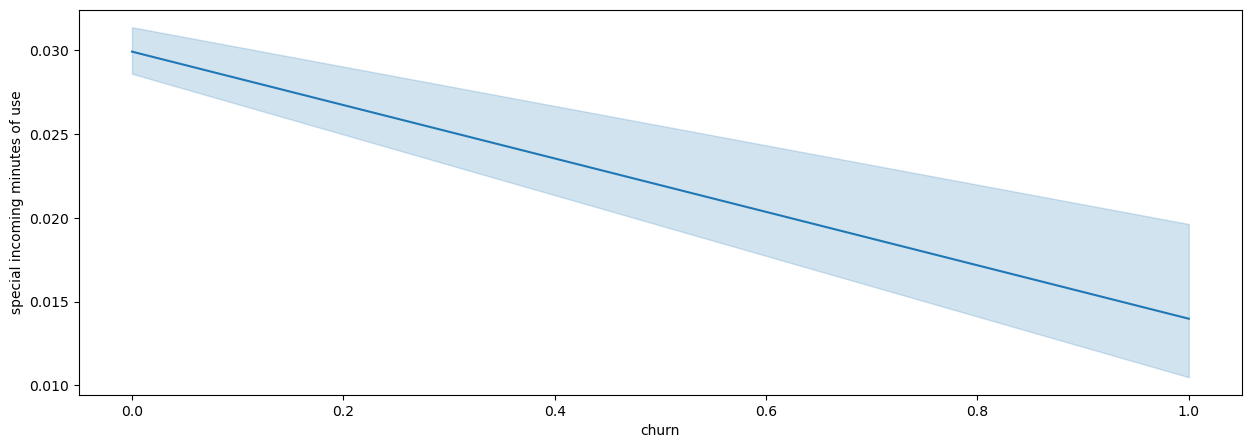

In [92]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['churn'],y=df['spl_ic_mou_8'])
plt.xlabel('churn')
plt.ylabel('special incoming minutes of use')
plt.show()